In [9]:
import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import time
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
import seaborn as sns
from sklearn.decomposition import PCA
## import torch
## import torch.nn as nn
## import torch.optim as optim

# SECTION 1 Feature Exploration

#### Load And Visualize Raw Data

In [2]:
# Path to your raw WISDM data file
file_path = r"C:\Users\bcott\OneDrive\Desktop\Boulder\2025 Fall Semester\MCEN4228 ML\MCEN4228 Final Project\DataCollected In Laboratory\WISDM_ar_v1.1_raw.txt"

clean_rows = []

with open(file_path, "r") as f:
    for line in f:
        # Remove any semicolons + strip whitespace
        line = line.replace(";", "").strip()

        # Split by comma
        parts = line.split(",")

        # Only keep rows with EXACTLY 6 fields
        if len(parts) != 6:
            continue

        user, activity, timestamp, x, y, z = parts

        try:
            # Try converting numeric values
            timestamp = float(timestamp)
            x = float(x)
            y = float(y)
            z = float(z)

            clean_rows.append([user, activity, timestamp, x, y, z])

        except ValueError:
            # Malformed numeric value → skip row
            continue

# Convert into DataFrame
raw_df = pd.DataFrame(clean_rows, columns=["user", "activity", "timestamp", "x", "y", "z"])

raw_df.head()

,user,activity,timestamp,x,y,z
0,33,Jogging,4.910596e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910606e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910611e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910622e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910633e+13,-1.184970,12.108489,7.205164


Using user 33, activity Jogging
Total samples for this user+activity: 2946
Window shape: (200, 6)


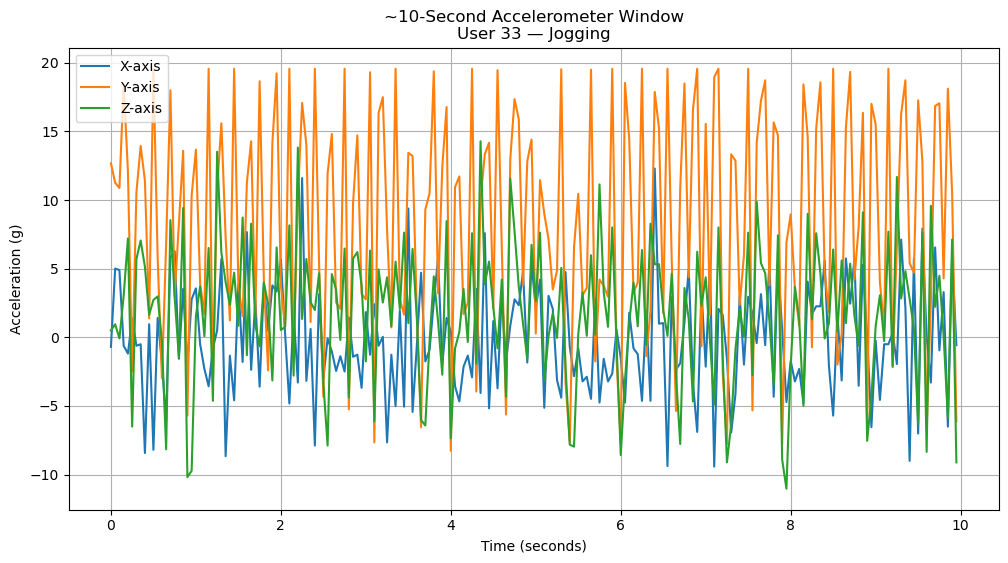

In [3]:
# ------------------------------------------------------
# 1. Pick the first user + activity pair that exists
# ------------------------------------------------------
first_row = raw_df.iloc[0]
user_id = first_row["user"]
activity = first_row["activity"]

print(f"Using user {user_id}, activity {activity}")

df_sample = raw_df[(raw_df["user"] == user_id) &
                   (raw_df["activity"] == activity)].copy()

# Make sure it's sorted
df_sample = df_sample.sort_values(by="timestamp").reset_index(drop=True)

print("Total samples for this user+activity:", len(df_sample))

# ------------------------------------------------------
# 2. Take a ~10-second window (first 200 samples)
# ------------------------------------------------------
window = df_sample.iloc[:200].copy()
print("Window shape:", window.shape)  # should be (200, 6) if enough samples

# Create a time axis assuming ~20 Hz sampling
fs = 20.0  # Hz (approximate)
t = np.arange(len(window)) / fs  # seconds

# ------------------------------------------------------
# 3. Plot the window (X, Y, Z vs time)
# ------------------------------------------------------
plt.figure(figsize=(12, 6))

plt.plot(t, window["x"], label="X-axis")
plt.plot(t, window["y"], label="Y-axis")
plt.plot(t, window["z"], label="Z-axis")

plt.title(f"~10-Second Accelerometer Window\nUser {user_id} — {activity}")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (g)")
plt.legend()
plt.grid(True)
plt.show()


#### Load And Visualize Transformed Data

In [4]:
# --- Step 1: Load transformed data using liac-arff ---

file_path = r"C:\Users\bcott\OneDrive\Desktop\Boulder\2025 Fall Semester\MCEN4228 ML\MCEN4228 Final Project\DataCollected In Laboratory\WISDM_ar_v1.1_transformed.arff"

with open(file_path, 'r') as f:
    dataset = arff.load(f)

# --- Step 2: Convert to a pandas DataFrame ---
df = pd.DataFrame(dataset['data'], columns=[attr[0] for attr in dataset['attributes']])

In [5]:
# --- Step 3: Decode byte strings (some ARFFs encode strings as bytes) ---
for col in df.select_dtypes(['object']).columns:
    if isinstance(df[col].iloc[0], bytes):
        df[col] = df[col].str.decode('utf-8')

# --- Step 4: Show summary info ---
print("✅ Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nColumns:", list(df.columns))
print("\nFirst few rows:")
display(df.head())

✅ Dataset loaded successfully!
Shape: (5418, 46)

Columns: ['UNIQUE_ID', 'user', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'RESULTANT', 'class']

First few rows:


,UNIQUE_ID,user,X0,X1,X2,X3,X4,X5,X6,X7,...,YPEAK,ZPEAK,XABSOLDEV,YABSOLDEV,ZABSOLDEV,XSTANDDEV,YSTANDDEV,ZSTANDDEV,RESULTANT,class
0,1.0,33,0.04,0.09,0.14,0.12,0.11,0.10,0.08,0.13,...,293.94,1550.00,3.29,7.21,4.00,4.05,8.17,4.05,11.96,Jogging
1,2.0,33,0.12,0.12,0.06,0.07,0.11,0.10,0.11,0.09,...,269.44,1233.33,4.23,6.88,4.05,5.43,8.19,5.43,12.05,Jogging
2,3.0,33,0.14,0.09,0.11,0.09,0.09,0.11,0.12,0.08,...,248.65,1780.00,4.18,6.89,4.07,5.55,8.19,5.55,11.99,Jogging
3,4.0,33,0.06,0.10,0.09,0.09,0.11,0.07,0.12,0.10,...,709.09,1380.00,2.26,4.13,2.49,2.87,4.95,2.87,10.69,Walking
4,5.0,33,0.12,0.11,0.10,0.08,0.10,0.14,0.10,0.11,...,3300.00,1775.00,2.29,3.94,2.41,3.08,4.64,3.08,10.80,Walking


##### Plot Histogram Bins

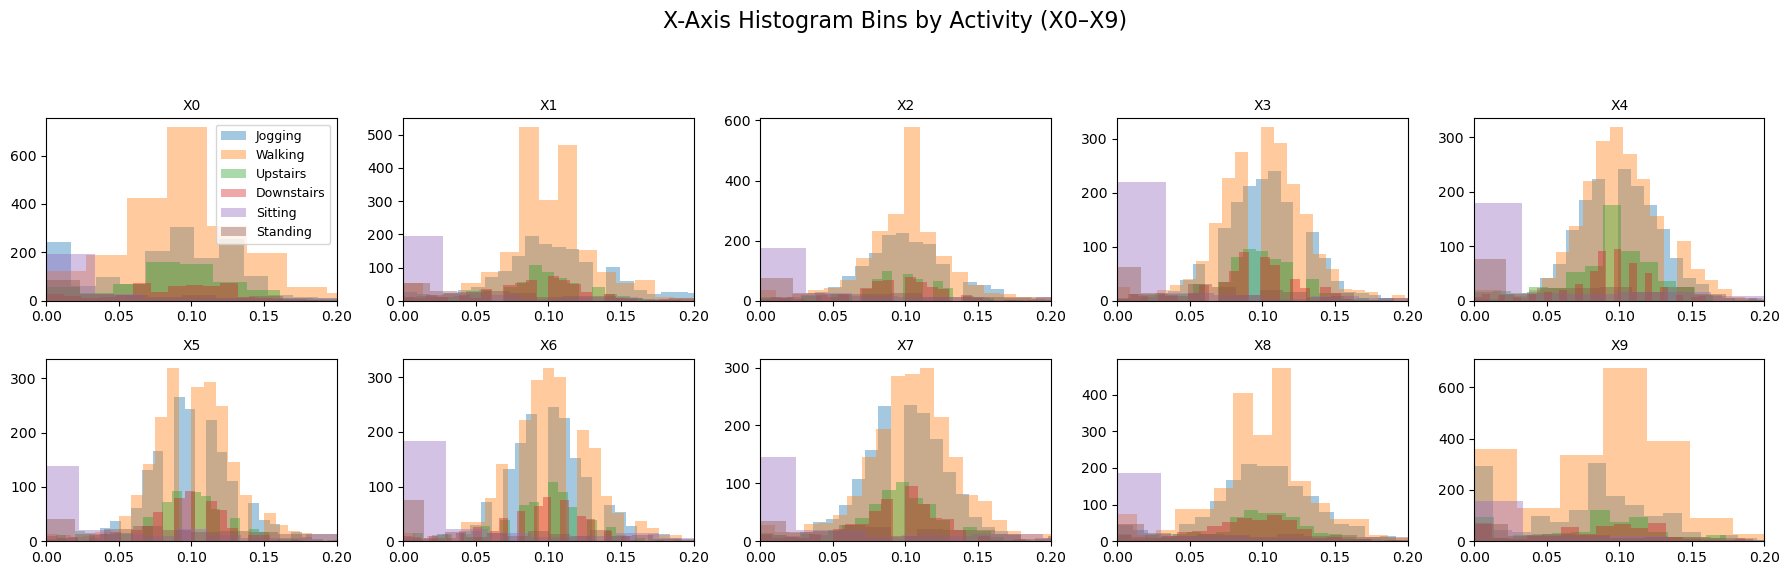

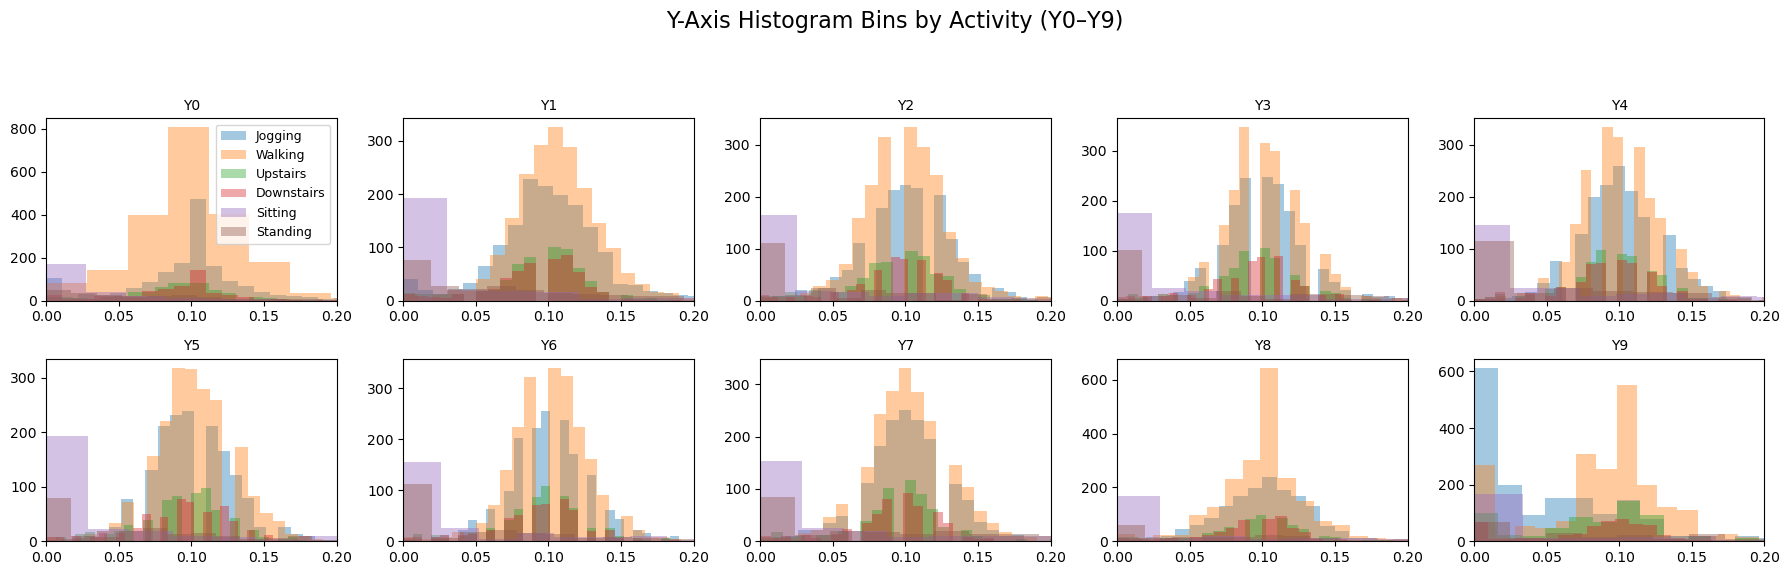

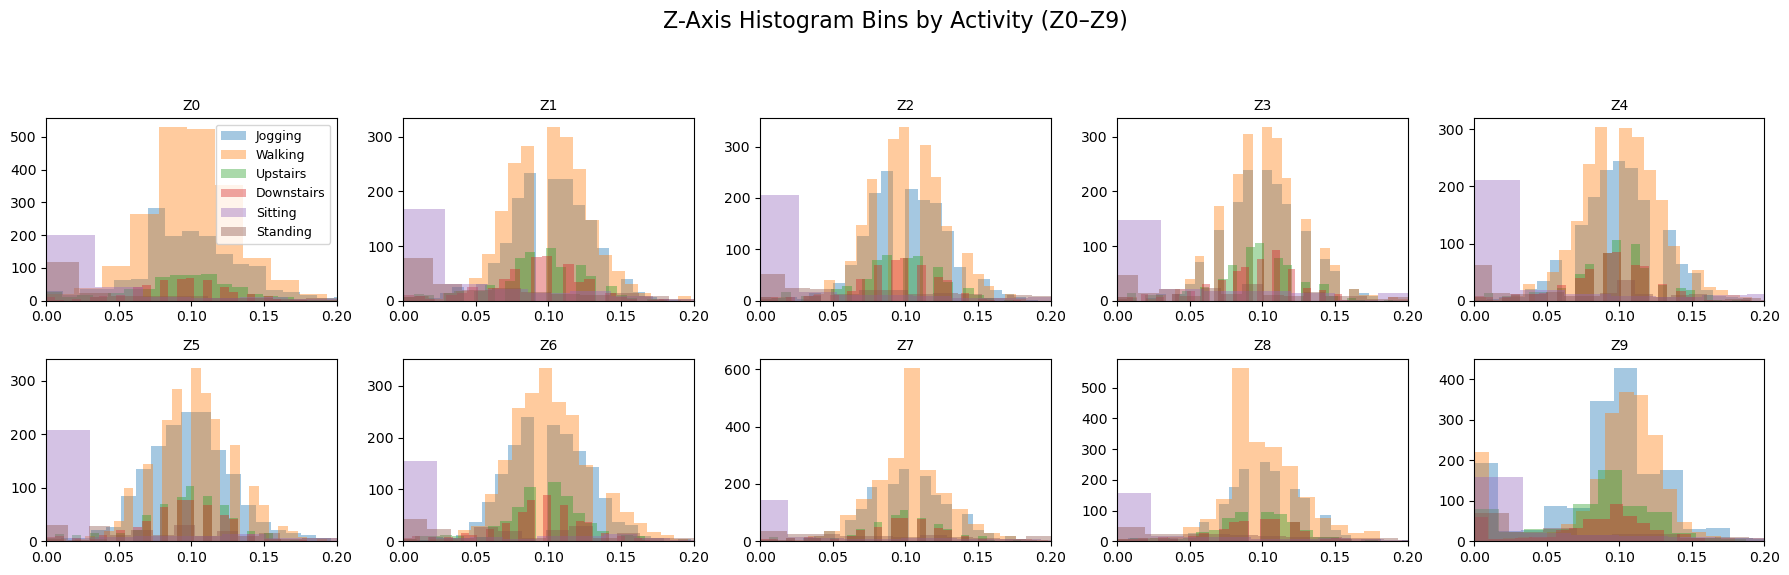

In [21]:
# --- 1. Define bin columns ---
x_cols = [f"X{i}" for i in range(10)]
y_cols = [f"Y{i}" for i in range(10)]
z_cols = [f"Z{i}" for i in range(10)]

# Keep only columns that exist
x_cols = [c for c in x_cols if c in df.columns]
y_cols = [c for c in y_cols if c in df.columns]
z_cols = [c for c in z_cols if c in df.columns]

# --- 2. Ensure numeric values ---
for col in x_cols + y_cols + z_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[x_cols + y_cols + z_cols] = df[x_cols + y_cols + z_cols].fillna(
    df[x_cols + y_cols + z_cols].mean(numeric_only=True)
)

# --- 3. Helper function to plot histograms by activity ---

def plot_hist_by_class(columns, title):
    activities = df["class"].unique()
    colors = plt.cm.tab10(range(len(activities)))  # up to 10 classes safely
    
    rows, cols = 2, 5  # 10 bins → 2×5 grid
    plt.figure(figsize=(18, 6))
    
    for i, col in enumerate(columns, 1):
        plt.subplot(rows, cols, i)
        
        for activity, color in zip(activities, colors):
            subset = df[df["class"] == activity]
            plt.hist(subset[col], bins=30, alpha=0.4, color=color, label=activity)
        
        plt.title(col, fontsize=10)
        plt.xlim(0, 0.2)
        plt.xlabel("")
        plt.ylabel("")
        if i == 1:
            plt.legend(fontsize=9)
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    plt.show()

# --- 4. Plot all axes color-coded by activity ---
plot_hist_by_class(x_cols, "X-Axis Histogram Bins by Activity (X0–X9)")
plot_hist_by_class(y_cols, "Y-Axis Histogram Bins by Activity (Y0–Y9)")
plot_hist_by_class(z_cols, "Z-Axis Histogram Bins by Activity (Z0–Z9)")


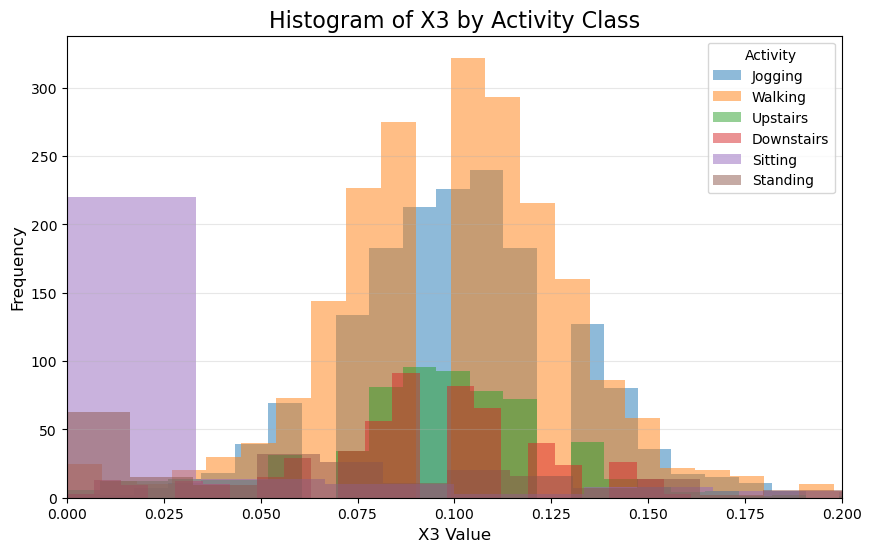

In [8]:
# Ensure X3 is numeric
df["X3"] = pd.to_numeric(df["X3"], errors="coerce")

activities = df["class"].unique()
colors = plt.cm.tab10(range(len(activities)))   # distinct color per class

plt.figure(figsize=(10, 6))

for activity, color in zip(activities, colors):
    subset = df[df["class"] == activity]
    plt.hist(
        subset["X3"],
        bins=30,
        alpha=0.5,
        color=color,
        label=activity
    )

plt.title("Histogram of X3 by Activity Class", fontsize=16)
plt.xlabel("X3 Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xlim(0, 0.2)   # optional — matches your earlier visual range
plt.grid(axis="y", alpha=0.3)
plt.legend(title="Activity", fontsize=10)

plt.show()


##### Plot Summary Statistics

<Figure size 1000x600 with 0 Axes>

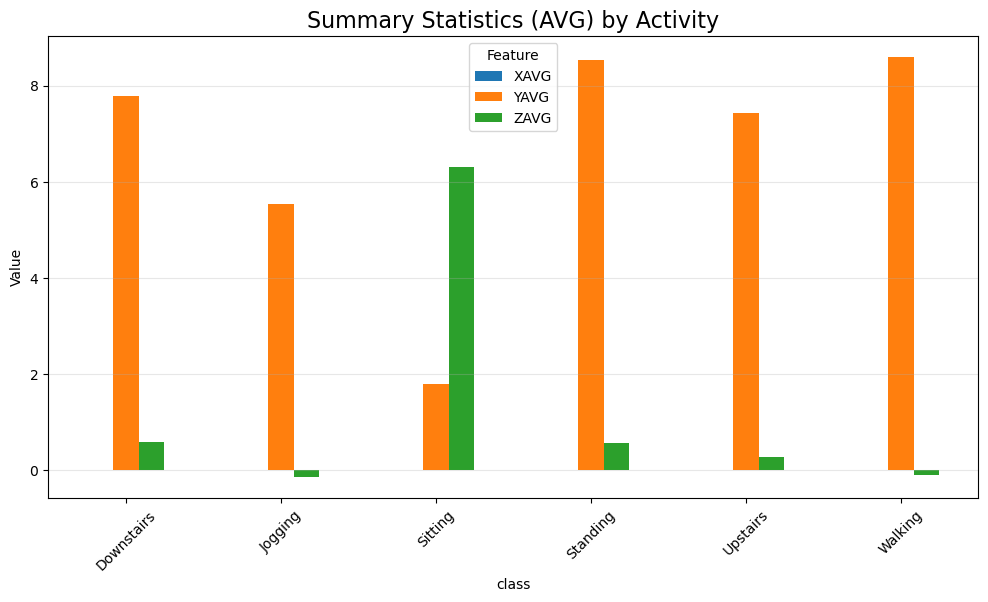

<Figure size 1000x600 with 0 Axes>

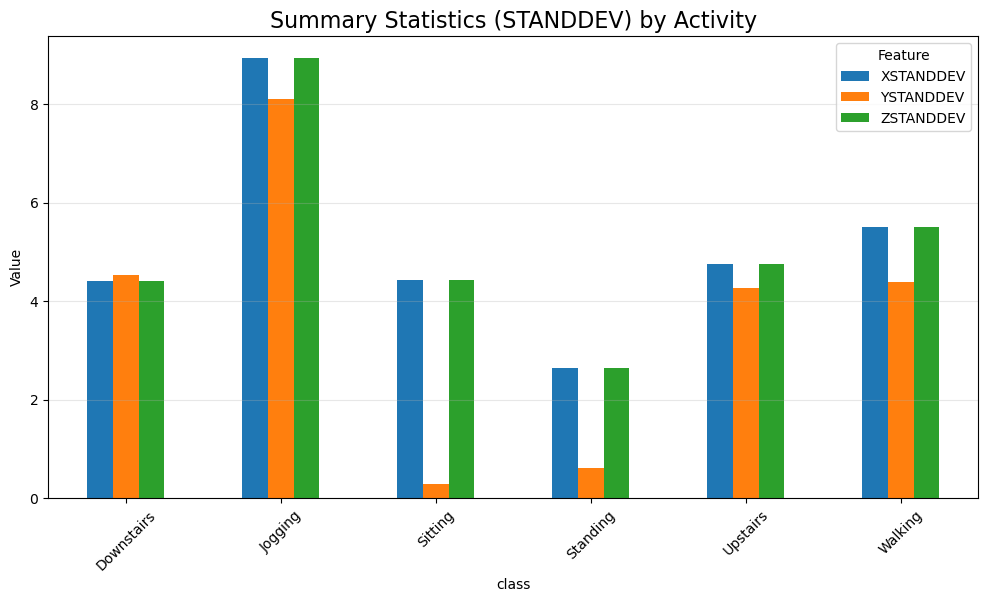

<Figure size 1000x600 with 0 Axes>

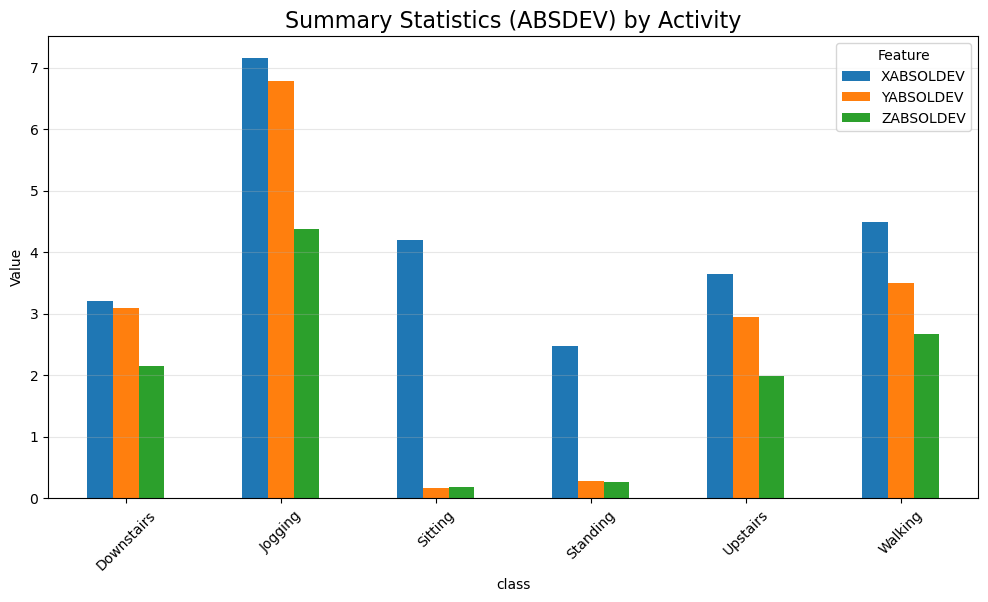

In [22]:
summary_groups = {
    "AVG": ["XAVG", "YAVG", "ZAVG"],
    "STANDDEV": ["XSTANDDEV", "YSTANDDEV", "ZSTANDDEV"],
    "ABSDEV": ["XABSOLDEV", "YABSOLDEV", "ZABSOLDEV"],
}

def plot_grouped_bar(df, cols, title):
    group_means = df.groupby("class")[cols].mean()

    plt.figure(figsize=(10, 6))
    group_means.plot(kind="bar", figsize=(12, 6))
    plt.title(title, fontsize=16)
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.legend(title="Feature")
    plt.show()

# Create grouped bar charts
plot_grouped_bar(df, summary_groups["AVG"], "Summary Statistics (AVG) by Activity")
plot_grouped_bar(df, summary_groups["STANDDEV"], "Summary Statistics (STANDDEV) by Activity")
plot_grouped_bar(df, summary_groups["ABSDEV"], "Summary Statistics (ABSDEV) by Activity")


##### Plot Peak Frequency Features

<Figure size 1000x600 with 0 Axes>

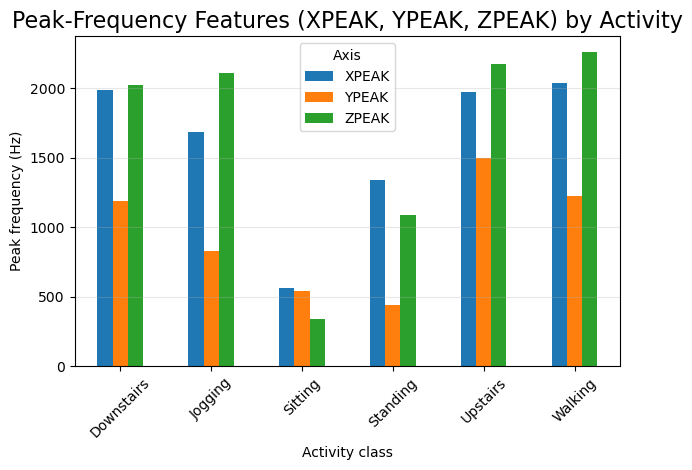

In [23]:
# Peak-frequency feature columns in your transformed df
peak_cols = ["XPEAK", "YPEAK", "ZPEAK"]

# Make sure they're numeric
for col in peak_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Mean peak values per activity (class)
peak_by_class = df.groupby("class")[peak_cols].mean()

plt.figure(figsize=(10, 6))
peak_by_class.plot(kind="bar")
plt.title("Peak-Frequency Features (XPEAK, YPEAK, ZPEAK) by Activity", fontsize=16)
plt.ylabel("Peak frequency (Hz)")
plt.xlabel("Activity class")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.legend(title="Axis")
plt.tight_layout()
plt.show()


# Section 2 Train Support Vector Machine (SVM) And Neural Network (NN) Models

#### Split Data Into Train (60%), Validation (20%), And Test (20%)

In [11]:
# ------------------------------------------------------------
# Split Data Into Train (60%), Validation (20%), And Test (20%)
# With Standardization (Z-score scaling)
# ------------------------------------------------------------
# --- Step 1: Separate features and labels ---
X = df.drop(columns=['UNIQUE_ID', 'user', 'class'], errors='ignore')
y = df['class']

# --- Step 2: Encode string labels as integers ---
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# --- Step 3: Split into Train (60%), Validation (20%), Test (20%) ---
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.4, stratify=y_encoded, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("✅ Data split complete!")
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

✅ Data split complete!
Train: (3250, 43), Validation: (1084, 43), Test: (1084, 43)


In [12]:
# --- Step 4: Standardize features ---
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# --- Step 5: Replace NaNs/Infs with zeros *in the scaled arrays* ---
X_train_scaled = np.nan_to_num(X_train_scaled, nan=0.0, posinf=0.0, neginf=0.0)
X_val_scaled   = np.nan_to_num(X_val_scaled,   nan=0.0, posinf=0.0, neginf=0.0)
X_test_scaled  = np.nan_to_num(X_test_scaled,  nan=0.0, posinf=0.0, neginf=0.0)


#### Linear SVM Models

In [9]:
# Hyperparameter grid
C_values = [0.01, 0.1, 1, 10, 100]

results = []
best_model = None
best_val_acc = -np.inf
best_C = None

for C in C_values:
    print(f"\nTraining LinearSVC with C = {C}")

    svm_clf = LinearSVC(
        C=C,
        dual=False,        # recommended when n_samples > n_features
        max_iter=10000,
        random_state=42
    )

    # --- Measure training time ---
    start_time = time.time()
    svm_clf.fit(X_train_scaled, y_train)        # <- cleaned data
    end_time = time.time()
    train_time = end_time - start_time

    # --- Validate the model ---
    y_val_pred = svm_clf.predict(X_val_scaled) # <- cleaned data
    val_acc = accuracy_score(y_val, y_val_pred)

    print(f"Training time: {train_time:.4f} sec")
    print(f"Validation accuracy: {val_acc:.4f}")

    # Save results
    results.append({
        "C": C,
        "train_time_sec": train_time,
        "val_accuracy": val_acc
    })

    # Track best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_C = C
        best_model = svm_clf

# Convert collected results to DataFrame
results_df = pd.DataFrame(results)

print("\n📊 Validation Results Over C Grid:")
print(results_df)

print(f"\n✅ BEST MODEL: C = {best_C} (Validation accuracy = {best_val_acc:.4f})")



Training LinearSVC with C = 0.01
Training time: 0.0747 sec
Validation accuracy: 0.7518

Training LinearSVC with C = 0.1
Training time: 0.0874 sec
Validation accuracy: 0.7685

Training LinearSVC with C = 1
Training time: 0.0888 sec
Validation accuracy: 0.7768

Training LinearSVC with C = 10
Training time: 0.0929 sec
Validation accuracy: 0.7786

Training LinearSVC with C = 100
Training time: 0.3791 sec
Validation accuracy: 0.7786

📊 Validation Results Over C Grid:
        C  train_time_sec  val_accuracy
0    0.01        0.074697      0.751845
1    0.10        0.087410      0.768450
2    1.00        0.088774      0.776753
3   10.00        0.092870      0.778598
4  100.00        0.379063      0.778598

✅ BEST MODEL: C = 10 (Validation accuracy = 0.7786)


#### Polynomial SVM Models

In [13]:
# Hyperparameter grid for polynomial SVM
C_values       = [0.1, 1, 10]
degrees        = [2, 3, 4]
gamma_values   = [0.001, 0.01, 0.1, 1, 10]    # 👈 NEW: numeric range for gamma
coef0_values   = [0.0, 1.0]

results = []
best_model = None
best_val_acc = -np.inf
best_params = None

for C in C_values:
    for degree in degrees:
        for gamma in gamma_values:
            for coef0 in coef0_values:

                print(f"\nTraining Poly SVM with C={C}, degree={degree}, gamma={gamma}, coef0={coef0}")

                svm_clf = SVC(
                    kernel="poly",
                    C=C,
                    degree=degree,
                    gamma=gamma,         # 👈 numeric gamma
                    coef0=coef0,
                    max_iter=-1,
                    random_state=42
                )

                # --- Training time ---
                start_time = time.time()
                svm_clf.fit(X_train_scaled, y_train)
                end_time = time.time()
                train_time = end_time - start_time

                # --- Validation ---
                y_val_pred = svm_clf.predict(X_val_scaled)
                val_acc = accuracy_score(y_val, y_val_pred)

                print(f"Training time: {train_time:.4f} sec")
                print(f"Validation accuracy: {val_acc:.4f}")

                # Store results
                results.append({
                    "C": C,
                    "degree": degree,
                    "gamma": gamma,
                    "coef0": coef0,
                    "train_time_sec": train_time,
                    "val_accuracy": val_acc
                })

                # Track best model
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model = svm_clf
                    best_params = {
                        "C": C,
                        "degree": degree,
                        "gamma": gamma,
                        "coef0": coef0
                    }

# Convert to DataFrame
poly_results_df = pd.DataFrame(results)

print("\n📊 Validation Results for Polynomial SVM Grid:")
print(poly_results_df.sort_values("val_accuracy", ascending=False))

print("\n✅ Best Polynomial SVM Parameters:")
print(best_params)
print(f"Best validation accuracy: {best_val_acc:.4f}")



Training Poly SVM with C=0.1, degree=2, gamma=0.001, coef0=0.0
Training time: 0.3991 sec
Validation accuracy: 0.3847

Training Poly SVM with C=0.1, degree=2, gamma=0.001, coef0=1.0
Training time: 0.3517 sec
Validation accuracy: 0.6301

Training Poly SVM with C=0.1, degree=2, gamma=0.01, coef0=0.0
Training time: 0.3795 sec
Validation accuracy: 0.5341

Training Poly SVM with C=0.1, degree=2, gamma=0.01, coef0=1.0
Training time: 0.2357 sec
Validation accuracy: 0.7399

Training Poly SVM with C=0.1, degree=2, gamma=0.1, coef0=0.0
Training time: 0.2717 sec
Validation accuracy: 0.7565

Training Poly SVM with C=0.1, degree=2, gamma=0.1, coef0=1.0
Training time: 0.1874 sec
Validation accuracy: 0.8072

Training Poly SVM with C=0.1, degree=2, gamma=1, coef0=0.0
Training time: 0.4294 sec
Validation accuracy: 0.7657

Training Poly SVM with C=0.1, degree=2, gamma=1, coef0=1.0
Training time: 0.3661 sec
Validation accuracy: 0.8026

Training Poly SVM with C=0.1, degree=2, gamma=10, coef0=0.0
Training 

#### RBF SVM Models

In [14]:
# --- Hyperparameter grid for RBF SVM ---
C_values     = [0.1, 1, 10, 100]
gamma_values = [0.001, 0.01, 0.1, 1]

results = []
best_model = None
best_val_acc = -np.inf
best_params = None

for C in C_values:
    for gamma in gamma_values:
        print(f"\nTraining RBF SVM with C={C}, gamma={gamma}")

        svm_clf = SVC(
            kernel="rbf",
            C=C,
            gamma=gamma,
            max_iter=-1,       # run until convergence
            random_state=42
        )

        # --- Measure training time ---
        start_time = time.time()
        svm_clf.fit(X_train_scaled, y_train)
        end_time = time.time()
        train_time = end_time - start_time

        # --- Validate ---
        y_val_pred = svm_clf.predict(X_val_scaled)
        val_acc = accuracy_score(y_val, y_val_pred)

        print(f"Training time: {train_time:.4f} sec")
        print(f"Validation accuracy: {val_acc:.4f}")

        # Save results
        results.append({
            "C": C,
            "gamma": gamma,
            "train_time_sec": train_time,
            "val_accuracy": val_acc
        })

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = svm_clf
            best_params = {
                "C": C,
                "gamma": gamma
            }

# Put results into a DataFrame
rbf_results_df = pd.DataFrame(results)

print("\n📊 Validation Results for RBF SVM Grid:")
print(rbf_results_df.sort_values("val_accuracy", ascending=False))

print("\n✅ Best RBF SVM Parameters:")
print(best_params)
print(f"Best validation accuracy: {best_val_acc:.4f}")



Training RBF SVM with C=0.1, gamma=0.001
Training time: 0.5105 sec
Validation accuracy: 0.6559

Training RBF SVM with C=0.1, gamma=0.01
Training time: 0.3464 sec
Validation accuracy: 0.7214

Training RBF SVM with C=0.1, gamma=0.1
Training time: 0.5427 sec
Validation accuracy: 0.6448

Training RBF SVM with C=0.1, gamma=1
Training time: 1.0987 sec
Validation accuracy: 0.3847

Training RBF SVM with C=1, gamma=0.001
Training time: 0.3475 sec
Validation accuracy: 0.7343

Training RBF SVM with C=1, gamma=0.01
Training time: 0.2566 sec
Validation accuracy: 0.7795

Training RBF SVM with C=1, gamma=0.1
Training time: 0.4801 sec
Validation accuracy: 0.7961

Training RBF SVM with C=1, gamma=1
Training time: 1.0419 sec
Validation accuracy: 0.3911

Training RBF SVM with C=10, gamma=0.001
Training time: 0.2345 sec
Validation accuracy: 0.7721

Training RBF SVM with C=10, gamma=0.01
Training time: 0.2430 sec
Validation accuracy: 0.8238

Training RBF SVM with C=10, gamma=0.1
Training time: 0.5616 sec


#### NN Models

###### ReLU Activation Function

In [18]:
# -----------------------------------------------------------------
# LARGE HYPERPARAMETER GRID FOR HIDDEN LAYERS (1–5 layers)
# -----------------------------------------------------------------

hidden_layer_sizes_list = [

    # 1-layer MLPs
    (32,), (64,), (128,), (256,),

    # 2-layer MLPs
    (64, 32),
    (128, 64),
    (256, 128),

    # 3-layer MLPs
    (128, 64, 32),
    (256, 128, 64),

    # 4-layer MLPs
    (256, 128, 64, 32),
    (128, 128, 64, 32),

    # 5-layer deep MLPs
    (256, 256, 128, 64, 32),
    (128, 128, 64, 64, 32)
]

learning_rates = [1e-4, 1e-3, 1e-2]
alphas = [1e-5, 1e-4, 1e-3, 1e-2]

results = []
best_mlp = None
best_val_acc = -np.inf
best_params = None

for hidden_layers in hidden_layer_sizes_list:
    for lr in learning_rates:
        for alpha in alphas:

            print(f"\nTraining MLP with hidden_layers={hidden_layers}, "
                  f"lr={lr}, alpha={alpha}")

            mlp_clf = MLPClassifier(
                hidden_layer_sizes=hidden_layers,
                activation="relu",
                solver="adam",
                learning_rate_init=lr,
                alpha=alpha,
                max_iter=300,
                early_stopping=True,
                n_iter_no_change=10,
                random_state=42,
                verbose=False
            )

            # --- Train and time it ---
            start_time = time.time()
            mlp_clf.fit(X_train_scaled, y_train)
            train_time = time.time() - start_time

            # --- Validation prediction ---
            y_val_pred = mlp_clf.predict(X_val_scaled)
            val_acc = accuracy_score(y_val, y_val_pred)

            print(f"Training time: {train_time:.4f} sec")
            print(f"Validation accuracy: {val_acc:.4f}")

            # Store results
            results.append({
                "hidden_layers": hidden_layers,
                "learning_rate_init": lr,
                "alpha": alpha,
                "train_time_sec": train_time,
                "val_accuracy": val_acc
            })

            # Track best configuration
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_mlp = mlp_clf
                best_params = {
                    "hidden_layers": hidden_layers,
                    "learning_rate_init": lr,
                    "alpha": alpha
                }

# -----------------------------------------------------------------
# RESULTS SUMMARY
# -----------------------------------------------------------------

results_df = pd.DataFrame(results)
print("\n📊 Top MLP Models Sorted by Validation Accuracy:")
print(results_df.sort_values("val_accuracy", ascending=False).head(15))

print("\n✅ Best MLP Parameters:")
print(best_params)
print(f"Best validation accuracy: {best_val_acc:.4f}")



Training MLP with hidden_layers=(32,), lr=0.0001, alpha=1e-05
Training time: 0.9166 sec
Validation accuracy: 0.7334

Training MLP with hidden_layers=(32,), lr=0.0001, alpha=0.0001
Training time: 0.9359 sec
Validation accuracy: 0.7334

Training MLP with hidden_layers=(32,), lr=0.0001, alpha=0.001
Training time: 0.8492 sec
Validation accuracy: 0.7334

Training MLP with hidden_layers=(32,), lr=0.0001, alpha=0.01
Training time: 0.8491 sec
Validation accuracy: 0.7334

Training MLP with hidden_layers=(32,), lr=0.001, alpha=1e-05
Training time: 0.6046 sec
Validation accuracy: 0.8072

Training MLP with hidden_layers=(32,), lr=0.001, alpha=0.0001
Training time: 0.4481 sec
Validation accuracy: 0.7970

Training MLP with hidden_layers=(32,), lr=0.001, alpha=0.001
Training time: 0.4553 sec
Validation accuracy: 0.7970

Training MLP with hidden_layers=(32,), lr=0.001, alpha=0.01
Training time: 0.6151 sec
Validation accuracy: 0.8081

Training MLP with hidden_layers=(32,), lr=0.01, alpha=1e-05
Trainin

###### Leaky ReLU

In [8]:
# Convert numpy to torch tensors
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.long)
X_val_t   = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t   = torch.tensor(y_val, dtype=torch.long)

# Define an MLP with variable depth + LeakyReLU
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_layers, output_dim, leak=0.01):
        super().__init__()

        layers = []
        prev = input_dim

        for h in hidden_layers:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.LeakyReLU(negative_slope=leak))
            prev = h
        
        layers.append(nn.Linear(prev, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

hidden_layer_sizes_list = [
    (32,), (64,), (128,), (256,),
    (64,32), (128,64), (256,128),
    (128,64,32), (256,128,64),
    (256,128,64,32),
    (256,256,128,64,32)
]

learning_rates = [1e-4, 1e-3, 1e-2]
weight_decays  = [0.0, 1e-5, 1e-4, 1e-3]   # L2 regularization in PyTorch


In [9]:
results = []
best_model = None
best_val_acc = -np.inf
best_params = None

input_dim = X_train_scaled.shape[1]
output_dim = len(np.unique(y_train))

for hidden_layers in hidden_layer_sizes_list:
    for lr in learning_rates:
        for wd in weight_decays:

            print(f"\nTraining MLP LeakyReLU with layers={hidden_layers}, lr={lr}, wd={wd}")

            model = MLP(input_dim, hidden_layers, output_dim, leak=0.01)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

            start_time = time.time()

            # Train for a few epochs
            for epoch in range(25):   # increase for more accuracy
                optimizer.zero_grad()
                preds = model(X_train_t)
                loss = criterion(preds, y_train_t)
                loss.backward()
                optimizer.step()

            train_time = time.time() - start_time

            # Validation
            with torch.no_grad():
                val_preds = model(X_val_t).argmax(dim=1).numpy()
                val_acc = accuracy_score(y_val, val_preds)

            print(f"Training time: {train_time:.3f} sec  |  Val Acc: {val_acc:.4f}")

            results.append({
                "hidden_layers": hidden_layers,
                "lr": lr,
                "weight_decay": wd,
                "train_time_sec": train_time,
                "val_accuracy": val_acc
            })

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model = model
                best_params = {
                    "hidden_layers": hidden_layers,
                    "lr": lr,
                    "weight_decay": wd
                }
results_df = pd.DataFrame(results)
print(results_df.sort_values("val_accuracy", ascending=False).head(15))

print("\nBest Model Params:")
print(best_params)
print(f"Best validation accuracy: {best_val_acc:.4f}")



Training MLP LeakyReLU with layers=(32,), lr=0.0001, wd=0.0
Training time: 0.032 sec  |  Val Acc: 0.2620

Training MLP LeakyReLU with layers=(32,), lr=0.0001, wd=1e-05
Training time: 0.027 sec  |  Val Acc: 0.1559

Training MLP LeakyReLU with layers=(32,), lr=0.0001, wd=0.0001
Training time: 0.027 sec  |  Val Acc: 0.3339

Training MLP LeakyReLU with layers=(32,), lr=0.0001, wd=0.001
Training time: 0.027 sec  |  Val Acc: 0.1393

Training MLP LeakyReLU with layers=(32,), lr=0.001, wd=0.0
Training time: 0.025 sec  |  Val Acc: 0.5987

Training MLP LeakyReLU with layers=(32,), lr=0.001, wd=1e-05
Training time: 0.024 sec  |  Val Acc: 0.4723

Training MLP LeakyReLU with layers=(32,), lr=0.001, wd=0.0001
Training time: 0.027 sec  |  Val Acc: 0.6218

Training MLP LeakyReLU with layers=(32,), lr=0.001, wd=0.001
Training time: 0.026 sec  |  Val Acc: 0.5812

Training MLP LeakyReLU with layers=(32,), lr=0.01, wd=0.0
Training time: 0.027 sec  |  Val Acc: 0.7491

Training MLP LeakyReLU with layers=(3

###### Tanh Activation Function

In [7]:
# -----------------------------------------------------------------
# Hyperparameter Grid (1–5 hidden layers)
# -----------------------------------------------------------------

hidden_layer_sizes_list = [

    # 1-layer
    (32,), (64,), (128,), (256,),

    # 2-layer
    (64, 32),
    (128, 64),
    (256, 128),

    # 3-layer
    (128, 64, 32),
    (256, 128, 64),

    # 4-layer
    (256, 128, 64, 32),
    (128, 128, 64, 32),

    # 5-layer
    (256, 256, 128, 64, 32),
    (128, 128, 64, 64, 32)
]

learning_rates = [1e-4, 1e-3, 1e-2]
alphas = [1e-5, 1e-4, 1e-3, 1e-2]

results = []
best_mlp = None
best_val_acc = -np.inf
best_params = None

for hidden_layers in hidden_layer_sizes_list:
    for lr in learning_rates:
        for alpha in alphas:

            print(f"\nTraining MLP (tanh) with hidden_layers={hidden_layers}, "
                  f"lr={lr}, alpha={alpha}")

            mlp_clf = MLPClassifier(
                hidden_layer_sizes=hidden_layers,
                activation="tanh",     # 👈 USE TANH ACTIVATION
                solver="adam",
                learning_rate_init=lr,
                alpha=alpha,           # L2 regularization
                max_iter=300,
                early_stopping=True,
                n_iter_no_change=10,
                random_state=42,
                verbose=False
            )

            # --- Train + timing ---
            start_time = time.time()
            mlp_clf.fit(X_train_scaled, y_train)
            train_time = time.time() - start_time

            # --- Validation ---
            y_val_pred = mlp_clf.predict(X_val_scaled)
            val_acc = accuracy_score(y_val, y_val_pred)

            print(f"Training time: {train_time:.4f} sec")
            print(f"Validation accuracy: {val_acc:.4f}")

            # Save results
            results.append({
                "hidden_layers": hidden_layers,
                "learning_rate_init": lr,
                "alpha": alpha,
                "train_time_sec": train_time,
                "val_accuracy": val_acc
            })

            # Track best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_mlp = mlp_clf
                best_params = {
                    "hidden_layers": hidden_layers,
                    "learning_rate_init": lr,
                    "alpha": alpha
                }

# -----------------------------------------------------------------
# Results Summary
# -----------------------------------------------------------------

results_df = pd.DataFrame(results)

print("\n📊 Top MLP (tanh) Models Sorted by Validation Accuracy:")
print(results_df.sort_values("val_accuracy", ascending=False).head(15))

print("\n✅ Best MLP Parameters (tanh):")
print(best_params)
print(f"Best validation accuracy: {best_val_acc:.4f}")



Training MLP (tanh) with hidden_layers=(32,), lr=0.0001, alpha=1e-05
Training time: 0.7782 sec
Validation accuracy: 0.7232

Training MLP (tanh) with hidden_layers=(32,), lr=0.0001, alpha=0.0001
Training time: 0.7862 sec
Validation accuracy: 0.7232

Training MLP (tanh) with hidden_layers=(32,), lr=0.0001, alpha=0.001
Training time: 0.8346 sec
Validation accuracy: 0.7232

Training MLP (tanh) with hidden_layers=(32,), lr=0.0001, alpha=0.01
Training time: 0.7902 sec
Validation accuracy: 0.7232

Training MLP (tanh) with hidden_layers=(32,), lr=0.001, alpha=1e-05
Training time: 0.2821 sec
Validation accuracy: 0.7740

Training MLP (tanh) with hidden_layers=(32,), lr=0.001, alpha=0.0001
Training time: 0.2838 sec
Validation accuracy: 0.7740

Training MLP (tanh) with hidden_layers=(32,), lr=0.001, alpha=0.001
Training time: 0.2685 sec
Validation accuracy: 0.7740

Training MLP (tanh) with hidden_layers=(32,), lr=0.001, alpha=0.01
Training time: 0.2903 sec
Validation accuracy: 0.7740

Training ML

###### Sigmoid Activation Function

In [8]:
# -----------------------------------------------------------------
# Hyperparameter Grid (1–5 hidden layers)
# -----------------------------------------------------------------

hidden_layer_sizes_list = [

    # 1-layer
    (32,), (64,), (128,), (256,),

    # 2-layer
    (64, 32),
    (128, 64),
    (256, 128),

    # 3-layer
    (128, 64, 32),
    (256, 128, 64),

    # 4-layer
    (256, 128, 64, 32),
    (128, 128, 64, 32),

    # 5-layer
    (256, 256, 128, 64, 32),
    (128, 128, 64, 64, 32)
]

learning_rates = [1e-4, 1e-3, 1e-2]
alphas = [1e-5, 1e-4, 1e-3, 1e-2]

results = []
best_mlp = None
best_val_acc = -np.inf
best_params = None

for hidden_layers in hidden_layer_sizes_list:
    for lr in learning_rates:
        for alpha in alphas:

            print(f"\nTraining MLP (sigmoid) with hidden_layers={hidden_layers}, "
                  f"lr={lr}, alpha={alpha}")

            mlp_clf = MLPClassifier(
                hidden_layer_sizes=hidden_layers,
                activation="logistic",  # 👈 USE SIGMOID ACTIVATION
                solver="adam",
                learning_rate_init=lr,
                alpha=alpha,
                max_iter=300,
                early_stopping=True,
                n_iter_no_change=10,
                random_state=42,
                verbose=False
            )

            # --- Train + timing ---
            start_time = time.time()
            mlp_clf.fit(X_train_scaled, y_train)
            train_time = time.time() - start_time

            # --- Validation ---
            y_val_pred = mlp_clf.predict(X_val_scaled)
            val_acc = accuracy_score(y_val, y_val_pred)

            print(f"Training time: {train_time:.4f} sec")
            print(f"Validation accuracy: {val_acc:.4f}")

            # Save results
            results.append({
                "hidden_layers": hidden_layers,
                "learning_rate_init": lr,
                "alpha": alpha,
                "train_time_sec": train_time,
                "val_accuracy": val_acc
            })

            # Track best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_mlp = mlp_clf
                best_params = {
                    "hidden_layers": hidden_layers,
                    "learning_rate_init": lr,
                    "alpha": alpha
                }

# --------------------------------------------------------------
# Results Summary
# --------------------------------------------------------------

results_df = pd.DataFrame(results)

print("\n📊 Top MLP (sigmoid) Models Sorted by Validation Accuracy:")
print(results_df.sort_values("val_accuracy", ascending=False).head(15))

print("\n✅ Best MLP Parameters (sigmoid):")
print(best_params)
print(f"Best validation accuracy: {best_val_acc:.4f}")



Training MLP (sigmoid) with hidden_layers=(32,), lr=0.0001, alpha=1e-05
Training time: 0.3203 sec
Validation accuracy: 0.5858

Training MLP (sigmoid) with hidden_layers=(32,), lr=0.0001, alpha=0.0001
Training time: 0.3000 sec
Validation accuracy: 0.5858

Training MLP (sigmoid) with hidden_layers=(32,), lr=0.0001, alpha=0.001
Training time: 0.2905 sec
Validation accuracy: 0.5858

Training MLP (sigmoid) with hidden_layers=(32,), lr=0.0001, alpha=0.01
Training time: 0.2592 sec
Validation accuracy: 0.5720

Training MLP (sigmoid) with hidden_layers=(32,), lr=0.001, alpha=1e-05
Training time: 0.3671 sec
Validation accuracy: 0.7648

Training MLP (sigmoid) with hidden_layers=(32,), lr=0.001, alpha=0.0001
Training time: 0.3682 sec
Validation accuracy: 0.7648

Training MLP (sigmoid) with hidden_layers=(32,), lr=0.001, alpha=0.001
Training time: 0.3293 sec
Validation accuracy: 0.7648

Training MLP (sigmoid) with hidden_layers=(32,), lr=0.001, alpha=0.01
Training time: 0.3614 sec
Validation accur

# Section 3 Retrain Best Performing SVM And NN Models And Evaluate Accuracy On Test Set

#### Combine Training And Validation Datasets

In [8]:
# Combine scaled training + validation features
X_train_final = np.vstack([X_train_scaled, X_val_scaled])

# Combine labels
y_train_final = np.concatenate([y_train, y_val])

print("Final training set shape:", X_train_final.shape)
print("Final training labels shape:", y_train_final.shape)

X_train_final, y_train_final = shuffle(
    X_train_final,
    y_train_final,
    random_state=42
)

Final training set shape: (4334, 43)
Final training labels shape: (4334,)


#### K-Fold Cross Validation For Best Performing Models

##### SVM RBF

In [9]:
# --------------------------------------------------
# 1. Define the base RBF SVM (no scaler here;
#    data is already standardized)
# --------------------------------------------------
svm_rbf = SVC(kernel="rbf", random_state=42)

# --------------------------------------------------
# 2. Hyperparameter grid for RBF SVM
#    C: regularization strength
#    gamma: RBF kernel width
# --------------------------------------------------
param_grid = {
    "C":     [0.1, 1, 10, 100, 1000],
    "gamma": [0.0001, 0.001, 0.01, 0.1, 1.0]
}

# --------------------------------------------------
# 3. Stratified k-fold CV
# --------------------------------------------------
k = 5  # or 10 if you want more stable estimates

cv = StratifiedKFold(
    n_splits=k,
    shuffle=True,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=svm_rbf,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# --------------------------------------------------
# 4. Run grid search on the COMBINED train+val set
# --------------------------------------------------
print("🔍 Starting Grid Search with RBF SVM on X_train_final...")
grid_search.fit(X_train_final, y_train_final)

print("\n✅ Grid search complete!")
print(f"Best mean CV accuracy: {grid_search.best_score_:.4f}")
print("Best hyperparameters:", grid_search.best_params_)

# Optional: inspect full CV results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results_sorted = cv_results.sort_values("mean_test_score", ascending=False)
print("\nTop 10 configurations by mean CV accuracy:")
print(cv_results_sorted[[
    "mean_test_score",
    "std_test_score",
    "param_C",
    "param_gamma",
    "mean_fit_time"
]].head(10))

🔍 Starting Grid Search with RBF SVM on X_train_final...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

✅ Grid search complete!
Best mean CV accuracy: 0.8362
Best hyperparameters: {'C': 100, 'gamma': 0.01}

Top 10 configurations by mean CV accuracy:
    mean_test_score  std_test_score  param_C  param_gamma  mean_fit_time
17         0.836174        0.011954    100.0       0.0100       0.886419
21         0.826950        0.010020   1000.0       0.0010       1.038005
12         0.822105        0.006947     10.0       0.0100       0.639958
22         0.806645        0.009946   1000.0       0.0100       1.589565
16         0.804108        0.005501    100.0       0.0010       0.596872
13         0.802720        0.010738     10.0       0.1000       1.468508
23         0.798336        0.012122   1000.0       0.1000       1.449596
18         0.798336        0.012122    100.0       0.1000       1.388221
20         0.796725        0.007295   1000.0       0.0001       0.649775
8    

###### Evaluate Accuracy Of SVM RBF With Optimal Hyperparameters

In [10]:
# --------------------------------------------------
# 5. Evaluate best model on the HELD-OUT TEST SET
# --------------------------------------------------
best_svm = grid_search.best_estimator_

y_test_pred = best_svm.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n🎯 Test accuracy of best RBF SVM: {test_acc:.4f}\n")

print("Classification report (test set):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


🎯 Test accuracy of best RBF SVM: 0.8423

Classification report (test set):
              precision    recall  f1-score   support

  Downstairs       0.49      0.44      0.47       106
     Jogging       0.97      0.99      0.98       325
     Sitting       0.91      0.97      0.94        61
    Standing       0.98      0.86      0.91        49
    Upstairs       0.63      0.50      0.56       127
     Walking       0.85      0.92      0.88       416

    accuracy                           0.84      1084
   macro avg       0.80      0.78      0.79      1084
weighted avg       0.83      0.84      0.84      1084



#### MLP NN Tanh Activation Function

In [15]:
# --------------------------------------------------
# 1. Expanded hidden-layer grid (your list)
# --------------------------------------------------

hidden_layer_sizes_list = [

    # 1-layer
    (32,), (64,), (128,), (256,),

    # 2-layer
    (64, 32),
    (128, 64),
    (256, 128),

    # 3-layer
    (128, 64, 32),
    (256, 128, 64),

    # 4-layer
    (256, 128, 64, 32),
    (128, 128, 64, 32),

    # 5-layer
    (256, 256, 128, 64, 32),
    (128, 128, 64, 64, 32)
]

# Learning rates and regularization strengths
learning_rates = [1e-4, 1e-3, 1e-2]
alphas = [1e-5, 1e-4, 1e-3, 1e-2]

# --------------------------------------------------
# 2. Base MLP model
# --------------------------------------------------

mlp_base = MLPClassifier(
    activation="tanh",
    solver="adam",
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42,
    verbose=False
)

# --------------------------------------------------
# 3. Parameter grid
# --------------------------------------------------

param_grid = {
    "hidden_layer_sizes": hidden_layer_sizes_list,
    "alpha": alphas,
    "learning_rate_init": learning_rates
}

# --------------------------------------------------
# 4. Stratified k-fold CV
# --------------------------------------------------

k = 5

cv = StratifiedKFold(
    n_splits=k,
    shuffle=True,
    random_state=42
)

# --------------------------------------------------
# 5. Grid Search
# --------------------------------------------------

grid_search_mlp = GridSearchCV(
    estimator=mlp_base,
    param_grid=param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("🔍 Starting Grid Search for MLP (tanh)...")
grid_search_mlp.fit(X_train_final, y_train_final)

print("\n✅ Grid search complete!")
print(f"Best mean CV accuracy: {grid_search_mlp.best_score_:.4f}")
print("Best hyperparameters:", grid_search_mlp.best_params_)

# --------------------------------------------------
# 6. Inspect top-performing configs
# --------------------------------------------------

cv_results = pd.DataFrame(grid_search_mlp.cv_results_)
cv_results_sorted = cv_results.sort_values("mean_test_score", ascending=False)

print("\nTop 10 tanh MLP configs by CV accuracy:")
print(cv_results_sorted[[
    "mean_test_score",
    "std_test_score",
    "param_hidden_layer_sizes",
    "param_alpha",
    "param_learning_rate_init"
]].head(10))


🔍 Starting Grid Search for MLP (tanh)...
Fitting 5 folds for each of 156 candidates, totalling 780 fits

✅ Grid search complete!
Best mean CV accuracy: 0.8477
Best hyperparameters: {'alpha': 0.01, 'hidden_layer_sizes': (256, 256, 128, 64, 32), 'learning_rate_init': 0.01}

Top 10 tanh MLP configs by CV accuracy:
     mean_test_score  std_test_score param_hidden_layer_sizes  param_alpha  \
152         0.847717        0.005945  (256, 256, 128, 64, 32)      0.01000   
149         0.847484        0.014593       (128, 128, 64, 32)      0.01000   
32          0.846794        0.005031       (128, 128, 64, 32)      0.00001   
155         0.845872        0.012703   (128, 128, 64, 64, 32)      0.01000   
31          0.845638        0.004078       (128, 128, 64, 32)      0.00001   
109         0.845638        0.004078       (128, 128, 64, 32)      0.00100   
70          0.845638        0.004078       (128, 128, 64, 32)      0.00010   
116         0.845409        0.010984   (128, 128, 64, 64, 32)  

###### Evaluate Accuracy Of MLP NN Tanh With Optimal Hyperparameters

In [16]:
# --------------------------------------------------
# 7. Evaluate best model on the held-out test set
# --------------------------------------------------

best_mlp_tanh = grid_search_mlp.best_estimator_

y_test_pred = best_mlp_tanh.predict(X_test_scaled)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n🎯 Test accuracy of best MLP (tanh): {test_acc:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))





🎯 Test accuracy of best MLP (tanh): 0.8635

Classification Report:
              precision    recall  f1-score   support

  Downstairs       0.55      0.44      0.49       106
     Jogging       0.97      0.98      0.98       325
     Sitting       0.92      0.95      0.94        61
    Standing       0.96      0.88      0.91        49
    Upstairs       0.59      0.66      0.62       127
     Walking       0.92      0.93      0.92       416

    accuracy                           0.86      1084
   macro avg       0.82      0.81      0.81      1084
weighted avg       0.86      0.86      0.86      1084



#### MLP NN Sigmoid Activation Function

In [17]:
# --------------------------------------------------
# 1. Expanded hidden-layer grid (same as before)
# --------------------------------------------------

hidden_layer_sizes_list = [

    # 1-layer
    (32,), (64,), (128,), (256,),

    # 2-layer
    (64, 32),
    (128, 64),
    (256, 128),

    # 3-layer
    (128, 64, 32),
    (256, 128, 64),

    # 4-layer
    (256, 128, 64, 32),
    (128, 128, 64, 32),

    # 5-layer
    (256, 256, 128, 64, 32),
    (128, 128, 64, 64, 32)
]

learning_rates = [1e-4, 1e-3, 1e-2]
alphas = [1e-5, 1e-4, 1e-3, 1e-2]

# --------------------------------------------------
# 2. Base MLP model with sigmoid (logistic) activation
# --------------------------------------------------

mlp_base_sigmoid = MLPClassifier(
    activation="logistic",   # 👈 sigmoid
    solver="adam",
    max_iter=300,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42,
    verbose=False
)

# --------------------------------------------------
# 3. Parameter grid
# --------------------------------------------------

param_grid_sigmoid = {
    "hidden_layer_sizes": hidden_layer_sizes_list,
    "alpha": alphas,
    "learning_rate_init": learning_rates
}

# --------------------------------------------------
# 4. Stratified k-fold CV
# --------------------------------------------------

k = 5

cv = StratifiedKFold(
    n_splits=k,
    shuffle=True,
    random_state=42
)

# --------------------------------------------------
# 5. Grid Search
# --------------------------------------------------

grid_search_mlp_sigmoid = GridSearchCV(
    estimator=mlp_base_sigmoid,
    param_grid=param_grid_sigmoid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

print("🔍 Starting Grid Search for MLP (sigmoid)...")
grid_search_mlp_sigmoid.fit(X_train_final, y_train_final)

print("\n✅ Grid search complete!")
print(f"Best mean CV accuracy (sigmoid): {grid_search_mlp_sigmoid.best_score_:.4f}")
print("Best hyperparameters (sigmoid):", grid_search_mlp_sigmoid.best_params_)

# --------------------------------------------------
# 6. Inspect top-performing configs
# --------------------------------------------------

cv_results_sigmoid = pd.DataFrame(grid_search_mlp_sigmoid.cv_results_)
cv_results_sigmoid_sorted = cv_results_sigmoid.sort_values("mean_test_score", ascending=False)

print("\nTop 10 sigmoid MLP configs by CV accuracy:")
print(cv_results_sigmoid_sorted[[
    "mean_test_score",
    "std_test_score",
    "param_hidden_layer_sizes",
    "param_alpha",
    "param_learning_rate_init"
]].head(10))


🔍 Starting Grid Search for MLP (sigmoid)...
Fitting 5 folds for each of 156 candidates, totalling 780 fits

✅ Grid search complete!
Best mean CV accuracy (sigmoid): 0.8565
Best hyperparameters (sigmoid): {'alpha': 0.001, 'hidden_layer_sizes': (256, 128, 64), 'learning_rate_init': 0.01}

Top 10 sigmoid MLP configs by CV accuracy:
     mean_test_score  std_test_score param_hidden_layer_sizes  param_alpha  \
104         0.856484        0.005172           (256, 128, 64)      0.00100   
107         0.855324        0.013668       (256, 128, 64, 32)      0.00100   
32          0.851866        0.014301       (128, 128, 64, 32)      0.00001   
110         0.850487        0.017646       (128, 128, 64, 32)      0.00100   
59          0.849791        0.010725               (256, 128)      0.00010   
20          0.848638        0.008934               (256, 128)      0.00001   
98          0.848407        0.009380               (256, 128)      0.00100   
23          0.848406        0.008749         

###### Evaluate Accuracy Of MLP NN Sigmoid With Optimal Hyperparameters

In [18]:
# --------------------------------------------------
# 7. Evaluate best sigmoid MLP on the held-out test set
# --------------------------------------------------

best_mlp_sigmoid = grid_search_mlp_sigmoid.best_estimator_

y_test_pred_sigmoid = best_mlp_sigmoid.predict(X_test_scaled)
test_acc_sigmoid = accuracy_score(y_test, y_test_pred_sigmoid)

print(f"\n🎯 Test accuracy of best MLP (sigmoid): {test_acc_sigmoid:.4f}\n")

print("Classification Report (sigmoid MLP):")
print(classification_report(y_test, y_test_pred_sigmoid, target_names=label_encoder.classes_))


🎯 Test accuracy of best MLP (sigmoid): 0.8635

Classification Report (sigmoid MLP):
              precision    recall  f1-score   support

  Downstairs       0.63      0.31      0.42       106
     Jogging       0.96      0.98      0.97       325
     Sitting       0.95      0.95      0.95        61
    Standing       0.94      0.94      0.94        49
    Upstairs       0.58      0.72      0.64       127
     Walking       0.90      0.94      0.92       416

    accuracy                           0.86      1084
   macro avg       0.83      0.81      0.81      1084
weighted avg       0.86      0.86      0.85      1084



# Section 4 Evaluate Best Models On Real World Data

#### Load And Process Real World Data

In [25]:
# --- Step 1: Load using liac-arff ---

file_path_real_world_data = r"C:\Users\bcott\OneDrive\Desktop\Boulder\2025 Fall Semester\MCEN4228 ML\MCEN4228 Final Project\Data Collected In Real World\WISDM_at_v2.0_transformed.arff"
with open(file_path_real_world_data, 'r') as f:
    dataset_2 = arff.load(f)

# --- Step 2: Convert to a pandas DataFrame ---
df_real_world = pd.DataFrame(dataset_2['data'], columns=[attr[0] for attr in dataset_2['attributes']])

In [26]:
# --- Step 3: Decode byte strings (some ARFFs encode strings as bytes) ---
for col in df_real_world.select_dtypes(['object']).columns:
    if isinstance(df_real_world[col].iloc[0], bytes):
        df_real_world[col] = df_real_world[col].str.decode('utf-8')

# --- Step 4: Show summary info ---
print("✅ Real-world dataset loaded successfully!")
print(f"Shape: {df_real_world.shape}")
print("\nColumns:", list(df_real_world.columns))
print("\nFirst few rows:")
display(df_real_world.head())


✅ Real-world dataset loaded successfully!
Shape: (5435, 45)

Columns: ['user', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'Y0', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7', 'Y8', 'Y9', 'Z0', 'Z1', 'Z2', 'Z3', 'Z4', 'Z5', 'Z6', 'Z7', 'Z8', 'Z9', 'XAVG', 'YAVG', 'ZAVG', 'XPEAK', 'YPEAK', 'ZPEAK', 'XABSOLDEV', 'YABSOLDEV', 'ZABSOLDEV', 'XSTANDDEV', 'YSTANDDEV', 'ZSTANDDEV', 'RESULTANT', 'class']

First few rows:


,user,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,YPEAK,ZPEAK,XABSOLDEV,YABSOLDEV,ZABSOLDEV,XSTANDDEV,YSTANDDEV,ZSTANDDEV,RESULTANT,class
0,194,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,642.000,0.0,0.116248,0.047219,0.139718,0.010264,0.004632,0.012177,10.6418,Standing
1,194,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,479.000,0.0,0.075843,0.032549,0.099133,0.007557,0.003087,0.009263,10.6413,Standing
2,194,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,479.000,0.0,0.075928,0.032858,0.100204,0.007561,0.003103,0.009316,10.6416,Standing
3,194,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,481.071,0.0,0.076094,0.032877,0.101254,0.007566,0.003102,0.009368,10.6416,Standing
4,194,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,481.071,0.0,0.075859,0.032892,0.102304,0.007562,0.003102,0.009419,10.6416,Standing


In [27]:
# Drop classes not present in training data
df_real_world = df_real_world[~df_real_world['class'].isin(['LyingDown', 'Stairs'])]

print("\nAfter dropping LyingDown and Stairs:")
print(df_real_world['class'].value_counts())



After dropping LyingDown and Stairs:
class
Walking     2185
Sitting     1410
Standing     840
Jogging      130
Name: count, dtype: int64


In [29]:
# ============================================================
# REAL-WORLD DATA: Use ENTIRE CLEANED DATASET AS TEST SET
# (NO SPLIT, NO SCALER REFIT)
# ============================================================

# df_real_world is assumed already loaded & decoded

# --- Step 1: Align features with LAB training features ---
# Use the SAME feature columns as X_train (same order)
X_real = df_real_world.drop(columns=['UNIQUE_ID', 'user', 'class'], errors='ignore')
X_real = X_real[X_train.columns]   # ensures identical columns & order

# --- Step 2: Encode real-world labels using the SAME label encoder ---
y_real_str = df_real_world['class']
y_real_all = label_encoder.transform(y_real_str)

# --- Step 3: Scale real-world features using the EXISTING scaler (NO REFIT) ---
X_real_all_scaled = scaler.transform(X_real)
X_real_all_scaled = np.nan_to_num(X_real_all_scaled, nan=0.0, posinf=0.0, neginf=0.0)

print("\n✅ Real-world FULL test set ready!")
print("Real-world feature shape:", X_real_all_scaled.shape)
print("Real-world label shape:",  y_real_all.shape)


✅ Real-world FULL test set ready!
Real-world feature shape: (4565, 43)
Real-world label shape: (4565,)


#### Evaluate BEST RBF SVM on the FULL REAL-WORLD DATASET

In [31]:
best_svm = grid_search.best_estimator_

# Predict on real-world data
y_real_pred = best_svm.predict(X_real_all_scaled)

# Accuracy
real_acc = accuracy_score(y_real_all, y_real_pred)
print(f"\n🌍 Real-world accuracy of best RBF SVM: {real_acc:.4f}\n")

# Get only the classes that actually appear in real-world labels
real_classes = np.unique(y_real_all)
real_class_names = label_encoder.inverse_transform(real_classes)

print("Classification report (real-world dataset):")
print(classification_report(
    y_real_all,
    y_real_pred,
    labels=real_classes,
    target_names=real_class_names
))


🌍 Real-world accuracy of best RBF SVM: 0.3093

Classification report (real-world dataset):
              precision    recall  f1-score   support

     Jogging       1.00      0.02      0.03       130
     Sitting       0.33      1.00      0.49      1410
    Standing       0.00      0.00      0.00       840
     Walking       0.00      0.00      0.00      2185

    accuracy                           0.31      4565
   macro avg       0.33      0.25      0.13      4565
weighted avg       0.13      0.31      0.15      4565



#### Evaluate BEST MLP NN (tanh) on the FULL REAL-WORLD DATASET

In [32]:
best_mlp_tanh = grid_search_mlp.best_estimator_

# Predict on real-world features
y_real_pred_mlp_tanh = best_mlp_tanh.predict(X_real_all_scaled)

# Real-world accuracy
real_acc_mlp_tanh = accuracy_score(y_real_all, y_real_pred_mlp_tanh)
print(f"\n🌍 Real-world accuracy of best MLP (tanh): {real_acc_mlp_tanh:.4f}\n")

# Only include the classes that actually appear in the real-world labels
real_classes = np.unique(y_real_all)
real_class_names = label_encoder.inverse_transform(real_classes)

print("Classification Report (real-world, MLP tanh):")
print(classification_report(
    y_real_all,
    y_real_pred_mlp_tanh,
    labels=real_classes,
    target_names=real_class_names
))



🌍 Real-world accuracy of best MLP (tanh): 0.2725

Classification Report (real-world, MLP tanh):
              precision    recall  f1-score   support

     Jogging       0.00      0.00      0.00       130
     Sitting       0.39      0.61      0.47      1410
    Standing       0.21      0.23      0.22       840
     Walking       0.81      0.09      0.16      2185

   micro avg       0.37      0.27      0.31      4565
   macro avg       0.35      0.23      0.21      4565
weighted avg       0.54      0.27      0.26      4565



#### Evaluate BEST MLP NN (sigmoid) on the FULL REAL-WORLD DATASET

In [34]:
best_mlp_sigmoid = grid_search_mlp_sigmoid.best_estimator_

# Predict on real-world features
y_real_pred_sigmoid = best_mlp_sigmoid.predict(X_real_all_scaled)

# Real-world accuracy
real_acc_sigmoid = accuracy_score(y_real_all, y_real_pred_sigmoid)
print(f"\n🌍 Real-world accuracy of best MLP (sigmoid): {real_acc_sigmoid:.4f}\n")

# Only include the classes that actually appear in real-world labels
real_classes = np.unique(y_real_all)
real_class_names = label_encoder.inverse_transform(real_classes)

print("Classification Report (real-world, MLP sigmoid):")
print(classification_report(
    y_real_all,
    y_real_pred_sigmoid,
    labels=real_classes,
    target_names=real_class_names
))


🌍 Real-world accuracy of best MLP (sigmoid): 0.2767

Classification Report (real-world, MLP sigmoid):
              precision    recall  f1-score   support

     Jogging       0.00      0.00      0.00       130
     Sitting       0.43      0.53      0.48      1410
    Standing       0.54      0.11      0.18       840
     Walking       0.67      0.19      0.30      2185

   micro avg       0.50      0.28      0.36      4565
   macro avg       0.41      0.21      0.24      4565
weighted avg       0.55      0.28      0.32      4565



C:\Users\bcott\anaconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bcott\anaconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\bcott\anaconda3\envs\mlenv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

# Section 5 Interpret Features Most Indicative Of Activity

In [11]:
result = permutation_importance(
    best_svm, 
    X_test_scaled,
    y_test,
    n_repeats=10,
    random_state=42
)

importances = result.importances_mean
feature_names = X_train.columns

# Sort top 10 features
indices = np.argsort(importances)[::-1]
top_features = [(feature_names[i], importances[i]) for i in indices[:10]]

print("Top 10 Important Features:")
for feat, score in top_features:
    print(f"{feat}: {score:.5f}")


Top 10 Important Features:
YABSOLDEV: 0.28718
YSTANDDEV: 0.19410
ZABSOLDEV: 0.13764
YAVG: 0.12362
RESULTANT: 0.07980
XABSOLDEV: 0.07915
ZAVG: 0.07260
XSTANDDEV: 0.05480
ZSTANDDEV: 0.05480
Z9: 0.01946


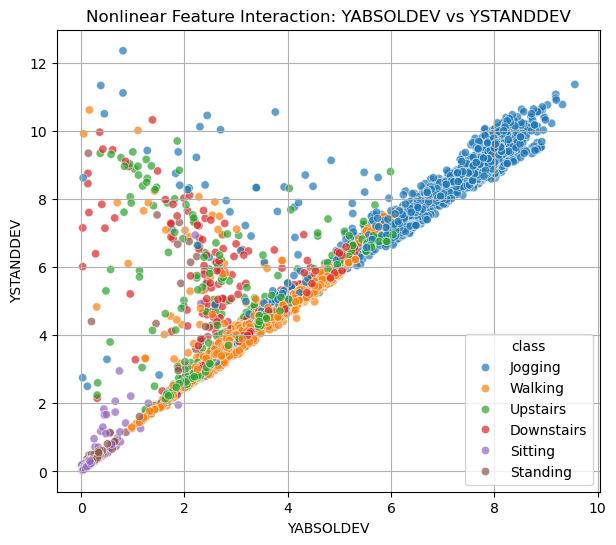

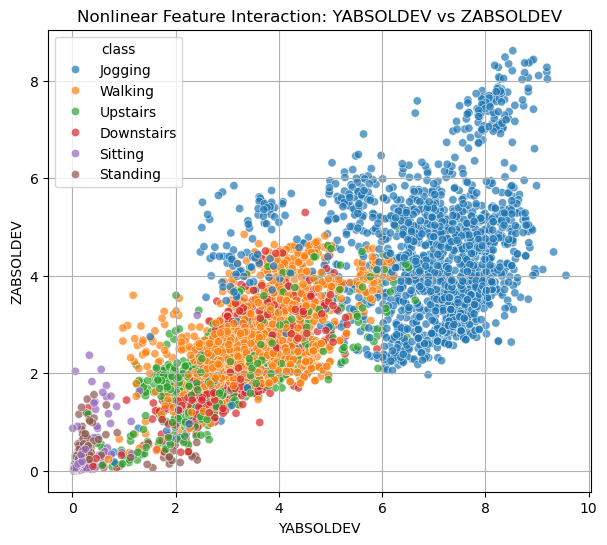

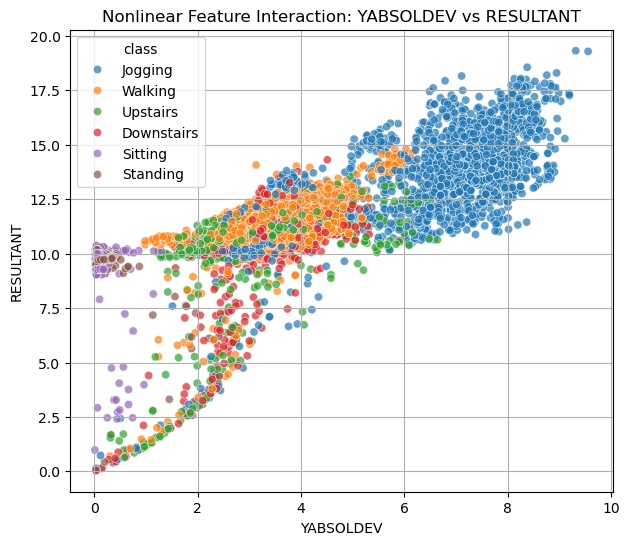

In [16]:
features_to_plot = [
    ("YABSOLDEV", "YSTANDDEV"),
    ("YABSOLDEV", "ZABSOLDEV"),
    ("YABSOLDEV", "RESULTANT")
]

for f1, f2 in features_to_plot:
    plt.figure(figsize=(7,6))
    sns.scatterplot(
        data=df,
        x=f1,
        y=f2,
        hue="class",
        palette="tab10",
        alpha=0.7
    )
    plt.title(f"Nonlinear Feature Interaction: {f1} vs {f2}")
    plt.grid(True)
    plt.show()


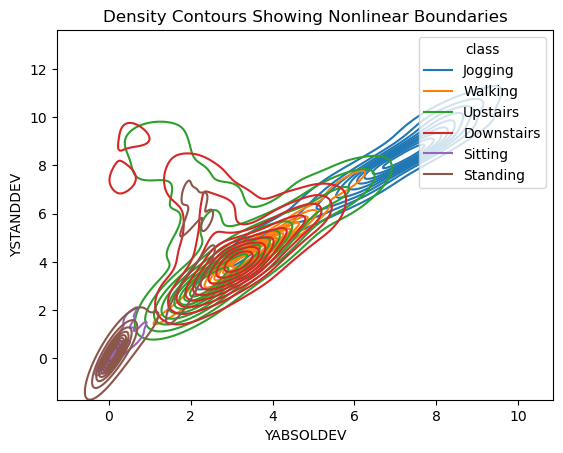

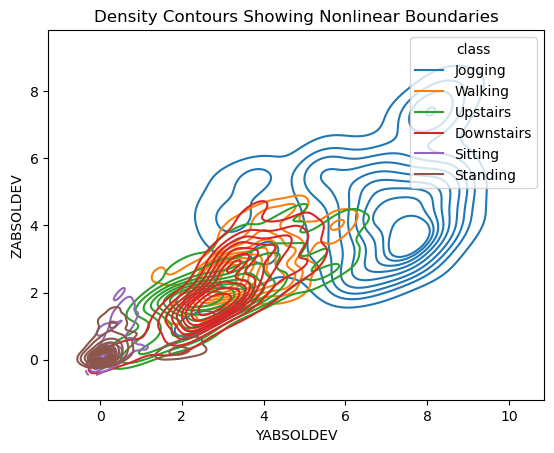

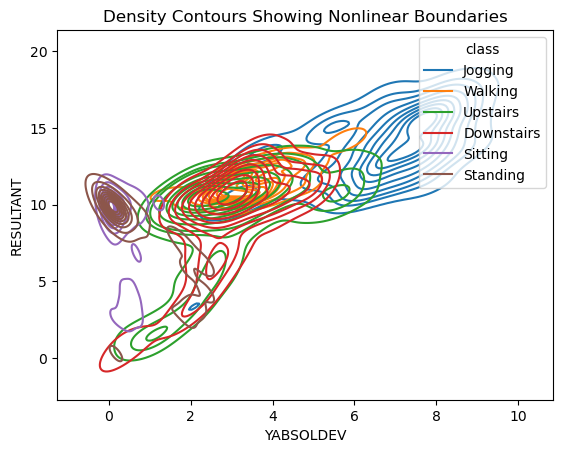

In [17]:
sns.kdeplot(
    data=df,
    x="YABSOLDEV",
    y="YSTANDDEV",
    hue="class",
    fill=False,
    common_norm=False
)
plt.title("Density Contours Showing Nonlinear Boundaries")
plt.show()

sns.kdeplot(
    data=df,
    x="YABSOLDEV",
    y="ZABSOLDEV",
    hue="class",
    fill=False,
    common_norm=False
)
plt.title("Density Contours Showing Nonlinear Boundaries")
plt.show()

sns.kdeplot(
    data=df,
    x="YABSOLDEV",
    y="RESULTANT",
    hue="class",
    fill=False,
    common_norm=False
)
plt.title("Density Contours Showing Nonlinear Boundaries")
plt.show()

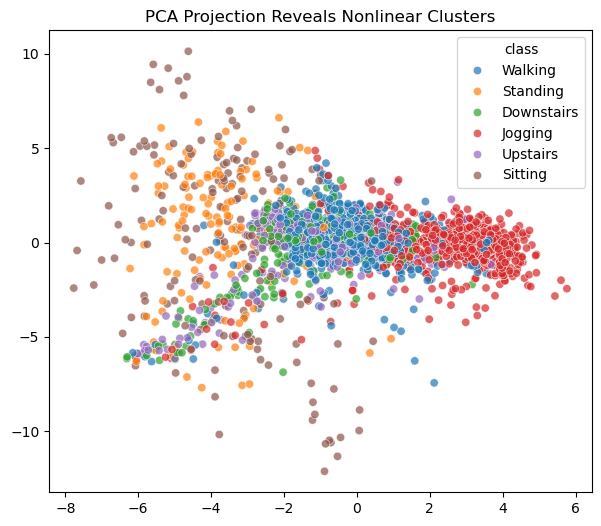

In [13]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

plt.figure(figsize=(7,6))
sns.scatterplot(
    x=X_pca[:,0],
    y=X_pca[:,1],
    hue=df.loc[X_train.index, "class"],
    palette="tab10",
    alpha=0.7
)
plt.title("PCA Projection Reveals Nonlinear Clusters")
plt.show()
